In [1]:
!pip install -q pyspark==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.5.1 which is incompatible.


In [2]:
!apt-get install openjdk-11-jdk-headless -qq
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

--2026-01-16 18:29:49--  https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz.1’

spark-3.5.1-bin-had 100%[===================>] 381.90M  7.50MB/s    in 35s     

2026-01-16 18:30:25 (10.9 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz.1’ saved [400446614/400446614]



In [3]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[*] pyspark-shell"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet

--2026-01-16 18:30:46--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 108.138.245.225, 108.138.245.16, 108.138.245.96, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|108.138.245.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38139949 (36M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2022-01.parquet’

yellow_tripdata_202 100%[===================>]  36.37M  17.1MB/s    in 2.1s    

2026-01-16 18:30:49 (17.1 MB/s) - ‘yellow_tripdata_2022-01.parquet’ saved [38139949/38139949]



In [6]:
!mkdir -p /content/drive/MyDrive/nyc_taxi

In [7]:
!mv yellow_tripdata_2022-01.parquet /content/drive/MyDrive/nyc_taxi/

In [8]:
!ls /content/drive/MyDrive/nyc_taxi

yellow_tripdata_2022-01.parquet


In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Spark Project") \
    .config("spark.ui.showConsoleProgress", "true") \
    .getOrCreate()

spark

In [10]:
spark.range(1, 10).show()

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [11]:
df = spark.read.parquet("/content/drive/MyDrive/nyc_taxi/")
df.count()
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [12]:
# Average fare
df.selectExpr("avg(fare_amount)").show()

# Trips per vendor
df.groupBy("VendorID").count().show()

# Peak hour analysis
from pyspark.sql.functions import hour
df.groupBy(hour("tpep_pickup_datetime")).count().orderBy("count", ascending=False).show()

+------------------+
|  avg(fare_amount)|
+------------------+
|12.946484016795376|
+------------------+

+--------+-------+
|VendorID|  count|
+--------+-------+
|       6|   5563|
|       5|     36|
|       1| 742273|
|       2|1716059|
+--------+-------+

+--------------------------+------+
|hour(tpep_pickup_datetime)| count|
+--------------------------+------+
|                        18|177696|
|                        17|176701|
|                        15|174416|
|                        16|168564|
|                        14|163858|
|                        19|151346|
|                        13|147878|
|                        12|142216|
|                        11|129561|
|                        10|119816|
|                        20|117997|
|                        21|109627|
|                         9|109376|
|                        22|104649|
|                         8|101528|
|                        23| 80209|
|                         7| 74137|
|                    

In [13]:
spark.conf.set("spark.sql.shuffle.partitions", "8")
df = df.repartition(8)
df.cache()
df.count()

2463931

In [14]:
df = spark.read.parquet("/content/drive/MyDrive/nyc_taxi/")

In [15]:
#Trips Per Vendor

In [16]:
vendor_trips = df.groupBy("VendorID").count()
vendor_trips.show()

+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|1716059|
|       5|     36|
|       1| 742273|
|       6|   5563|
+--------+-------+



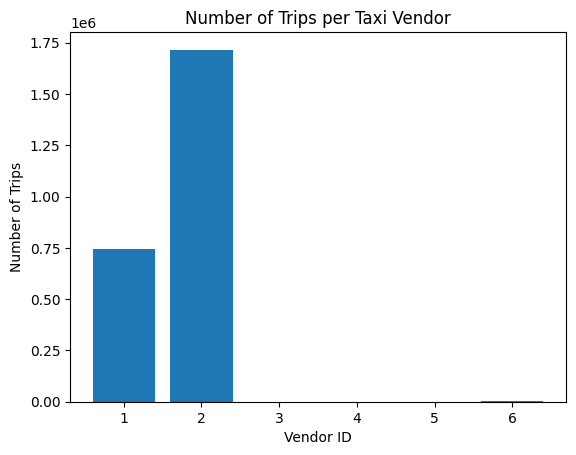

In [17]:
vendor_pd = vendor_trips.toPandas()

import matplotlib.pyplot as plt

plt.figure()
plt.bar(vendor_pd["VendorID"], vendor_pd["count"])
plt.xlabel("Vendor ID")
plt.ylabel("Number of Trips")
plt.title("Number of Trips per Taxi Vendor")
plt.show()

In [18]:
#Average Fare by Passenger Count

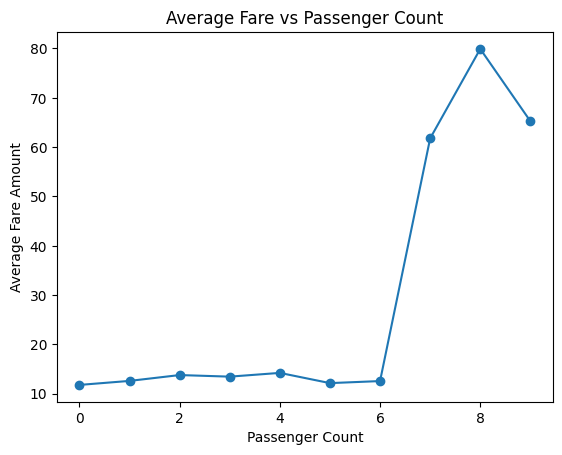

In [19]:
fare_passenger = df.groupBy("passenger_count") \
                   .avg("fare_amount") \
                   .orderBy("passenger_count")

fare_pd = fare_passenger.toPandas()

plt.figure()
plt.plot(fare_pd["passenger_count"], fare_pd["avg(fare_amount)"], marker='o')
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare Amount")
plt.title("Average Fare vs Passenger Count")
plt.show()

In [20]:
#Peak Hour Traffic

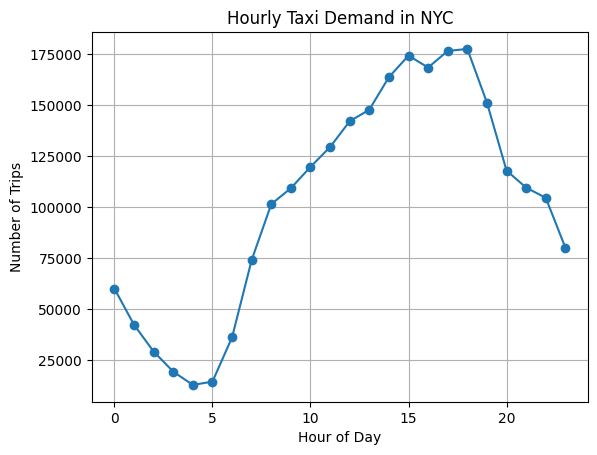

In [21]:
from pyspark.sql.functions import hour

hourly_trips = df.groupBy(hour("tpep_pickup_datetime").alias("Hour")) \
                 .count() \
                 .orderBy("Hour")

hourly_pd = hourly_trips.toPandas()

plt.figure()
plt.plot(hourly_pd["Hour"], hourly_pd["count"], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Taxi Demand in NYC")
plt.grid(True)
plt.show()

In [22]:
#Fare Distribution

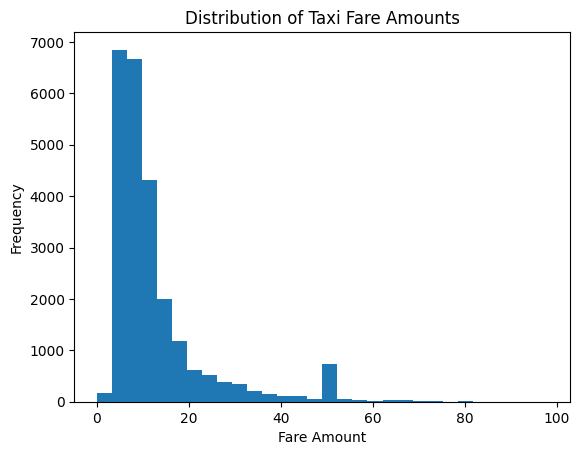

In [23]:
fare_df = df.select("fare_amount") \
            .where("fare_amount > 0 AND fare_amount < 100")

fare_pd = fare_df.sample(fraction=0.01).toPandas()  # sample to avoid memory issues

plt.figure()
plt.hist(fare_pd["fare_amount"], bins=30)
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Taxi Fare Amounts")
plt.show()

In [24]:
#Trip Distance vs Fare

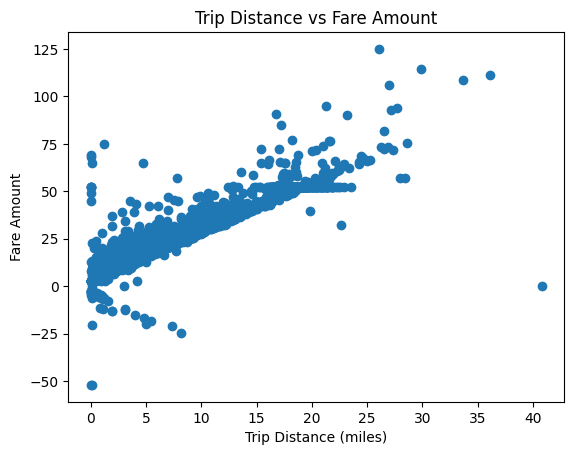

In [25]:
dist_fare = df.select("trip_distance", "fare_amount") \
              .where("trip_distance > 0 AND trip_distance < 50")

dist_pd = dist_fare.sample(fraction=0.005).toPandas()

plt.figure()
plt.scatter(dist_pd["trip_distance"], dist_pd["fare_amount"])
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")
plt.show()

In [26]:
#Before vs After Optimization Graph

+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|1716059|
|       5|     36|
|       1| 742273|
|       6|   5563|
+--------+-------+

+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|1716059|
|       5|     36|
|       1| 742273|
|       6|   5563|
+--------+-------+



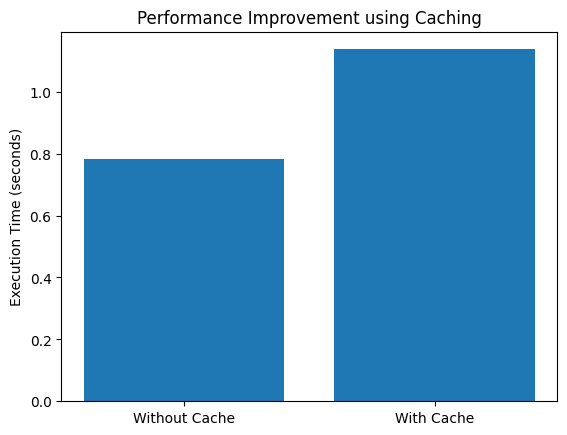

In [27]:
import time

start = time.time()
df.groupBy("VendorID").count().show()
no_cache_time = time.time() - start

df.cache()
df.count()

start = time.time()
df.groupBy("VendorID").count().show()
cache_time = time.time() - start

plt.figure()
plt.bar(["Without Cache", "With Cache"], [no_cache_time, cache_time])
plt.ylabel("Execution Time (seconds)")
plt.title("Performance Improvement using Caching")
plt.show()